In [9]:
import intake
import numpy as np
import matplotlib.pyplot as plt
from cmip6_preprocessing.preprocessing import combined_preprocessing

url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,523774
dcpp_init_year,60


One rarely uses the full archive, and usually we want to search for a subset of data. Subsets are defined by 'facets' (shown above). 

So for instance, if we only want to look at the historical forcing experiment, we can search for it like this:

In [3]:
cat = col.search(experiment_id = 'historical')
cat

,unique
activity_id,1
institution_id,31
source_id,65
experiment_id,1
member_id,201
table_id,34
variable_id,648
grid_label,9
zstore,86693
dcpp_init_year,0


Thats still a lot of data, so lets search for several facets at the same time to get this down to a bunch of datasets we can use in the tutorial

In [4]:
cat = col.search(
    experiment_id = 'historical',
    variable_id='so',
    table_id='Omon',
    grid_label='gn',
)
cat

,unique
activity_id,1
institution_id,27
source_id,52
experiment_id,1
member_id,182
table_id,1
variable_id,1
grid_label,1
zstore,548
dcpp_init_year,0


Here we picked the ocean salinity `so` variable for monthly output (`Omon`) and the native grid (`gn`). You can explore other variables [here]().

Lets see which models are available in this subset:

In [5]:
np.sort(cat.df['source_id'].unique())

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR',
       'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2',
       'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM',
       'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1',
       'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE', 'EC-Earth3',
       'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-Veg',
       'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0',
       'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC',
       'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'ICON-ESM-LR',
       'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR', 'IPSL-CM6A-LR-INCA',
       'MCM-UA-1-0', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM-1-2-HAM',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1',
       'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1',
       'UKESM1-0-LL'], dtype=object)

Thats a lot. We will chose only three models here as an example, but feel free to plug in anyone of the ones shown above!

In [6]:
cat = col.search(
    experiment_id = 'historical',
    variable_id='so',
    table_id='Omon',
    grid_label='gn',
    source_id=['MPI-ESM1-2-HR', 'CanESM5-CanOE', 'GFDL-ESM4']
)
cat

,unique
activity_id,1
institution_id,3
source_id,3
experiment_id,1
member_id,13
table_id,1
variable_id,1
grid_label,1
zstore,13
dcpp_init_year,0


Ok time to load the datasets into a dictionary. Note that this is only 'lazily' loading the data, which means we only access the metadata, and the full output is only loaded once we perform a computation!

In [8]:
datasets_dict = cat.to_dataset_dict(
    zarr_kwargs={'use_cftime':True,'consolidated':True},
    aggregate=False,
    preprocess=combined_preprocessing
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Now lets do something really simple: Plot the surface salinity at the first timestep

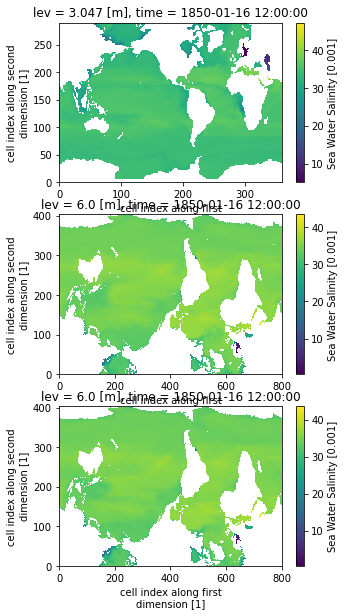

In [12]:
fig, axarr = plt.subplots(nrows=3, figsize=[5,10])
for ds, ax in zip(datasets_dict.values(), axarr.flat):
    ds.isel(time=0, lev=0).so.plot(ax=ax)